# Stock Closing Price Prediction Using CNN-BiLSTM and Transformer

## Library Importing

In [1]:
# Python Standard Libraries
import os
import csv
import math
import random
import unicodedata

# Data Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP - NLTK
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LSTM, Bidirectional,
    Conv1D, Conv2D, MaxPooling1D, MaxPooling2D,
    Flatten, GlobalAveragePooling1D, LayerNormalization,
    MultiHeadAttention, Add, Attention, Permute, Concatenate, Lambda
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.losses import Huber

# XGBoost
import xgboost as xgb
from xgboost import XGBRegressor

# Shap
import shap

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/yourth/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Data Importing

In [2]:
company_list = ['TSLA', 'AAPL', 'AMZN', 'GOOGL', 'MSFT']
stock_data_dict = {}

for symbol in company_list:
    path = f"./data/filtered/{symbol}_filtered.csv"
    stock_data_dict[symbol] = pd.read_csv(path)

In [3]:
stock = 'TSLA'

## Train Test Split

In [97]:
def data_integration(stock, n_past=8, n_future=1):
    df = stock_data_dict[stock]

    # 1. Data Lagging
    # Lag technical indicators to avoid leakage
    lag_cols = [
        'Adj Close', 'High', 'Low', 'Volume', 'SMA_5', 'SMA_20',
        'BB_Mid', 'BB_Std', 'BB_Upper', 'BB_Lower',
        'RSI_14', 'Log_Return', 'OBV', 'Vader_Polarity'
    ]

    for col in lag_cols:
        if col == "Adj Close":
            df[f"{col} (lag1)"] = df[col].shift(1)
        else:
            df[col] = df[col].shift(1)

    feature_cols = [
        'Adj Close',  # should be the first one for Y
        'Adj Close (lag1)',
        'SMA_5',              # short-term trend
        'Volume',
        'BB_Mid',           # risk signal
        'Log_Return',
        'DayOfWeek', 
        'Month',
        'Vader_Polarity'  # should be the last one for SENTIMENT
    ]

    df = df[feature_cols]

    train_size = 0.7
    train_split_idx = int(train_size * len(df))

    df_filtered = df[feature_cols]
    df_filtered = df_filtered.iloc[1:] # delete nan ❗去掉第一天（因为 lag1 没有值）

    # Step 0: Define split boundaries BEFORE scaling
    train_df = df_filtered.iloc[:train_split_idx]
    test_df  = df_filtered.iloc[train_split_idx:]

    # Step 1: Fit scaler only on training data (Avoid Data Leakage)
    scaler = MinMaxScaler()
    scaler.fit(train_df)

    scaler_target = MinMaxScaler()
    scaler_target.fit(train_df[['Adj Close']])

    # Step 2: Scale training and test data separately
    train_scaled = scaler.transform(train_df)
    test_scaled  = scaler.transform(test_df)

    # Step 3: For inference later, only scale ['Adj Close']
    scaler_for_inference = MinMaxScaler()
    actual_scaled_close = scaler_for_inference.fit_transform(
        df_filtered[['Adj Close']]
    )

    # Step 3: Reconstruct sliding windows for train and test
    def create_sequences(data, n_past, n_future):
        X, y = [], []
        for i in range(n_past, len(data) - n_future + 1):
            X.append(data[i - n_past:i, 1:])
            y.append(data[i + n_future - 1:i + n_future, [0]])  # Predict Adj Close
        return np.array(X), np.array(y)

    trainX, trainY = create_sequences(train_scaled, n_past, n_future)
    testX, testY   = create_sequences(test_scaled, n_past, n_future)

    # trainY = trainY.reshape(-1, 1)
    # testY = testY.reshape(-1, 1)

    # Without Sentiment (Baseline Model)
    trainX_wo_tweet = trainX[:, :, :-1]  # Exclude last feature
    testX_wo_tweet  = testX[:, :, :-1]
    trainY_wo_tweet = trainY
    testY_wo_tweet  = testY

    # With Sentiment (Tweet-based Model)
    # trainX_with_tweet = trainX
    # testX_with_tweet  = testX
    # trainY_with_tweet = trainY
    # testY_with_tweet  = testY

    return df, scaler, trainX, trainY, testX, testY, trainX_wo_tweet, testX_wo_tweet, trainY_wo_tweet, testY_wo_tweet, scaler_for_inference, scaler_target

In [98]:
df, scaler, trainX, trainY, testX, testY, trainX_wo_tweet, testX_wo_tweet, trainY_wo_tweet, testY_wo_tweet, scaler_for_inference, scaler_target = data_integration(stock=stock)

In [99]:
# after you call data_integration(...)
print("Any NaNs in trainX?", np.isnan(trainX).any())
print("Any NaNs in trainY?", np.isnan(trainY).any())
print("Any NaNs in testX? ", np.isnan(testX).any())

Any NaNs in trainX? True
Any NaNs in trainY? False
Any NaNs in testX?  False


In [100]:
print(f"trainX: {trainX.shape}")
print(f"trainY: {trainY.shape}")
print(f"testX: {testX.shape}")
print(f"testY: {testY.shape}")
print()
print(f"trainX_wo_tweet: {trainX_wo_tweet.shape}")
print(f"testX_wo_tweet: {testX_wo_tweet.shape}")
print(f"trainY_wo_tweet: {trainY_wo_tweet.shape}")
print(f"testY_wo_tweet: {testY_wo_tweet.shape}")

trainX: (872, 8, 8)
trainY: (872, 1, 1)
testX: (369, 8, 8)
testY: (369, 1, 1)

trainX_wo_tweet: (872, 8, 7)
testX_wo_tweet: (369, 8, 7)
trainY_wo_tweet: (872, 1, 1)
testY_wo_tweet: (369, 1, 1)


## CNN-BiLSTM

### 1. Configuration

In [101]:
def cnn_biLSTM(input_shape, output_dim):
    inputs = Input(shape=input_shape)

    x = Conv1D(128, kernel_size=2, strides=1, padding='valid')(inputs)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    x = Conv1D(64, kernel_size=2, strides=1, padding='valid')(x)
    x = MaxPooling1D(pool_size=1, strides=2)(x)

    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Dropout(0.2)(x)

    # === Add attention here ===
    # attn_out = Attention(use_scale=True)([x, x])  # Self-attention: query = value = key = x
    # x = GlobalAveragePooling1D()(attn_out)

    x = Dense(32, activation='relu')(x)
    outputs = Dense(output_dim, activation='relu')(x)

    return Model(inputs, outputs)

In [102]:
# # Build models
cnnBiLSTM_woSent = cnn_biLSTM(
    (trainX_wo_tweet.shape[1], trainX_wo_tweet.shape[2]), trainY.shape[2]
)
cnnBiLSTM_woSent.compile(
    optimizer=Adam(learning_rate=0.001),
    # loss=integrated_loss(delta=0.1, lambda_dir=0.16),  # 👈 adjust as needed
    # loss='mse',  # 👈 adjust as needed
    loss=Huber(0.1),
    metrics=['mae']
)

In [103]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,         # ← good default
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [104]:
# after you call data_integration(...)
print("Any NaNs in trainX?", np.isnan(trainX).any())
print("Any NaNs in trainY?", np.isnan(trainY).any())
print("Any NaNs in testX? ", np.isnan(testX).any())

Any NaNs in trainX? True
Any NaNs in trainY? False
Any NaNs in testX?  False


In [105]:
# Fit models
history_cnnBiLSTM_woSent = cnnBiLSTM_woSent.fit(
    trainX_wo_tweet,
    trainY_wo_tweet,
    epochs=50,
    batch_size=64,
    validation_data=(testX_wo_tweet, testY_wo_tweet),  # ← use your test split here
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan - learning_rate: 0.0010
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan - learning_rate: 0.0010
Epoch 3/50
 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: nan - mae: nan 
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan - learning_rate: 0.0010
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan - learning_rate: 5.0000e-04
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan - learning_rate: 5.0000e-04
Epoch 6/50
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: nan - mae: nan 
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: nan - mae: n

### 2. Tuning

In [75]:
# # Fit models
# history_cnnBiLSTM_woSent = cnnBiLSTM_woSent.fit(
#     trainX_wo_tweet,
#     trainY_wo_tweet,
#     epochs=50,
#     batch_size=64,
#     validation_data=(testX_wo_tweet, testY_wo_tweet),  # ← use your test split here
#     verbose=1,
#     callbacks=[early_stop, reduce_lr]
# )

### 3. Best Parameter for CNN-BiLSTM

1. Learning Rate: 0.001
2. Huber loss: delta = 0.1
3. Early Stop: patience = 20
4. Reduce LR: factor=0.5, patience=3, min_lr=1e-6,

## Transformer

### 1. Configuration

In [76]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_len, d_model):
        super().__init__()
        self.pos_encoding = self.positional_encoding(sequence_len, d_model)

    def get_config(self):
        return {"sequence_len": self.pos_encoding.shape[0], "d_model": self.pos_encoding.shape[1]}

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                     np.arange(d_model)[np.newaxis, :],
                                     d_model)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        return tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

In [77]:
# # ========== 1. Transformer Encoder ==========
# def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout):
#     """
#     Builds a single Transformer encoder block.
#     """
#     # Multi-head self-attention
#     attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(inputs, inputs)
#     attention_output = Add()([inputs, attention_output])
#     attention_output = LayerNormalization()(attention_output)

#     # Feed-forward network
#     ffn_output = Dense(ff_dim, activation='relu')(attention_output)
#     # ffn_output = Dropout(dropout)(ffn_output)  # <--- Dropout after first FFN layer
#     ffn_output = Dense(inputs.shape[-1])(ffn_output)
#     ffn_output = Add()([attention_output, ffn_output])
#     output = LayerNormalization()(ffn_output)

#     return output

# def build_transformer_model(input_shape, head_size=64, num_heads=4, ff_dim=128, num_layers=2, dropout=0.1):
#     inputs = Input(shape=input_shape)
#     x = PositionalEncoding(input_shape[0], input_shape[1])(inputs)  # add positional encoding

#     for _ in range(num_layers):
#         x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

#     x = GlobalAveragePooling1D()(x)
#     outputs = Dense(1)(x)
#     return Model(inputs, outputs)

In [78]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.15, epsilon=1e-6, kernel_size=1):
    # Pre-LN Self Attention
    x = layers.LayerNormalization(epsilon=epsilon)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    x = layers.Add()([x, inputs])

    # Feed-forward block
    y = layers.LayerNormalization(epsilon=epsilon)(x)
    y = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation='relu')(y)
    y = layers.Dropout(dropout)(y)
    y = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(y)
    return layers.Add()([x, y])

def build_transformer_model(input_shape, head_size=64, num_heads=4, ff_dim=128,
                            num_layers=2, dropout=0.15, mlp_units=[64], mlp_dropout=0.1):
    inputs = Input(shape=input_shape)
    x = PositionalEncoding(input_shape[0], input_shape[1])(inputs)

    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D()(x)
    for units in mlp_units:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(1)(x)
    return Model(inputs, outputs)

### 2. Tuning

In [79]:
# # ========== Train model without sentiment ==========
transformer_woSent = build_transformer_model((trainX_wo_tweet.shape[1], trainX_wo_tweet.shape[2]))
transformer_woSent.compile(
    optimizer=Adam(0.001), 
    # loss=integrated_loss(), 
    loss=Huber(0.05),
    # loss='mse',
    metrics=['mae']
) 
# # history_wo_sent = model_wo_sent.fit(  # ✅ save history here
# #     trainX_wo_tweet, trainY_wo_tweet,
# #     validation_data=(testX_wo_tweet, testY_wo_tweet),
# #     epochs=50, batch_size=64, verbose=1,
# #     callbacks=[early_stop_wo, reduce_lr]
# # )

### 3. Best Parameter for Transformer

1. Learning Rate: 0.001
2. Huber loss: delta = 0.05
3. Early Stop: patience = 15
4. Reduce LR: factor=0.5, patience=3, min_lr=1e-5,

## Ensemble

In [80]:
early_stop_cnn = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

reduce_lr_cnn = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,         # ← good default
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [81]:
# For Transformer *without* sentiment (cleaner input, stop sooner)
early_stop_tran = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr_tran = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,         # ← good default
    patience=3,
    min_lr=1e-5,
    verbose=1
)

In [82]:
# ==================== Train Base Models ====================
# 1. Train CNN+BiLSTM model
cnnBiLSTM_woSent.fit(
    trainX_wo_tweet, trainY_wo_tweet,
    epochs=50,
    batch_size=64,
    validation_data=(testX_wo_tweet, testY_wo_tweet),
    verbose=0,
    callbacks=[early_stop_cnn, reduce_lr_cnn]
)
trainY_pred_cnn = cnnBiLSTM_woSent.predict(trainX_wo_tweet)
# 2. Train Transformer model
transformer_woSent.fit(
    trainX_wo_tweet, trainY_wo_tweet,
    epochs=50,
    batch_size=64,
    validation_data=(testX_wo_tweet, testY_wo_tweet),
    verbose=0,
    callbacks=[early_stop_tran, reduce_lr_tran]
)
trainY_pred_transformer = transformer_woSent.predict(trainX_wo_tweet)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 18: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 21: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 27: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 30: ReduceLROnPlateau reducing learning rate to 1e-05.
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [83]:
print(trainY_pred_cnn.shape)
print(trainY_pred_transformer.shape)


(875, 1, 1)
(875, 1)


In [84]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

tscv = TimeSeriesSplit(n_splits=5)
meta_features, meta_labels = [], []

for fold, (train_idx, val_idx) in enumerate(tscv.split(trainX_wo_tweet)):
    print(f"\n=== Fold {fold+1} ===")
    X_train, X_val = trainX_wo_tweet[train_idx], trainX_wo_tweet[val_idx]
    y_train, y_val = trainY_wo_tweet[train_idx], trainY_wo_tweet[val_idx]

    # Build and compile CNN model
    cnn_model = cnn_biLSTM((X_train.shape[1], X_train.shape[2]), 1)
    cnn_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=Huber(0.1),
        metrics=['mae']
    )

    # Build and compile Transformer model
    transformer_model = build_transformer_model((X_train.shape[1], X_train.shape[2]))
    transformer_model.compile(
        optimizer=Adam(0.001),
        # loss=Huber(0.05),
        loss='mse',
        metrics=['mae']
    )

    # Fresh callbacks
    early_stop_cnn = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    reduce_lr_cnn = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=0)

    early_stop_tran = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr_tran = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=0)

    # Train models
    cnn_model.fit(X_train, y_train, epochs=50, batch_size=64,
                  validation_data=(X_val, y_val), verbose=0,
                  callbacks=[early_stop_cnn, reduce_lr_cnn])

    transformer_model.fit(X_train, y_train, epochs=50, batch_size=64,
                          validation_data=(X_val, y_val), verbose=0,
                          callbacks=[early_stop_tran, reduce_lr_tran])

    # Predict fold val set
    pred_cnn = cnn_model.predict(X_val).reshape(-1, 1)
    pred_tran = transformer_model.predict(X_val).reshape(-1, 1)

    meta_features.append(np.hstack([pred_cnn, pred_tran]))
    meta_labels.append(y_val)


=== Fold 1 ===
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

=== Fold 2 ===
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

=== Fold 3 ===
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

=== Fold 4 ===
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

=== Fold 5 ===
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [85]:
# Final meta-training data
X_meta_train = np.vstack(meta_features)
y_meta_train = np.concatenate(meta_labels)

# FIX: reshape y to 1D
if y_meta_train.ndim == 3:
    y_meta_train = y_meta_train.reshape(-1)
elif y_meta_train.ndim == 2:
    y_meta_train = y_meta_train.flatten()

# # Train meta-model (Linear Regression)
# meta_model = LinearRegression()
# meta_model.fit(X_meta_train, y_meta_train)

### Weighted Averaging Ensemble

In [86]:
# y_pred_avg = X_meta_train.mean(axis=1)  # (N,) shape
y_pred_avg = 0.9 * X_meta_train[:, 0] + 0.1 * X_meta_train[:, 1]

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n📊 {name}")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   MAE : {mae:.4f}")
    print(f"   R²  : {r2:.4f}")

evaluate_model("Simple Averaging Ensemble", y_meta_train, y_pred_avg)


📊 Simple Averaging Ensemble
   RMSE: 0.0632
   MAE : 0.0488
   R²  : 0.9317


In [87]:
# Base predictions (scaled or inverse-transformed)
y_pred_cnn = cnnBiLSTM_woSent.predict(testX_wo_tweet).reshape(-1, 1)
y_pred_tran = transformer_woSent.predict(testX_wo_tweet).reshape(-1, 1)

y_pred_cnn = scaler_target.inverse_transform(y_pred_cnn).flatten()
y_pred_tran = scaler_target.inverse_transform(y_pred_tran).flatten()
true_test = scaler_target.inverse_transform(testY_wo_tweet.reshape(-1, 1)).flatten()

y_pred_avg = (y_pred_cnn + y_pred_tran) / 2
evaluate_model("Simple Averaging", true_test, y_pred_avg)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 Simple Averaging
   RMSE: 1.2904
   MAE : 0.9884
   R²  : 0.8580



📊 CNN+BiLSTM
   RMSE: 1.2261
   MAE : 0.9125
   R²  : 0.8718

📊 Transformer
   RMSE: 1.4602
   MAE : 1.1670
   R²  : 0.8181

📊 Simple Averaging
   RMSE: 1.2904
   MAE : 0.9884
   R²  : 0.8580


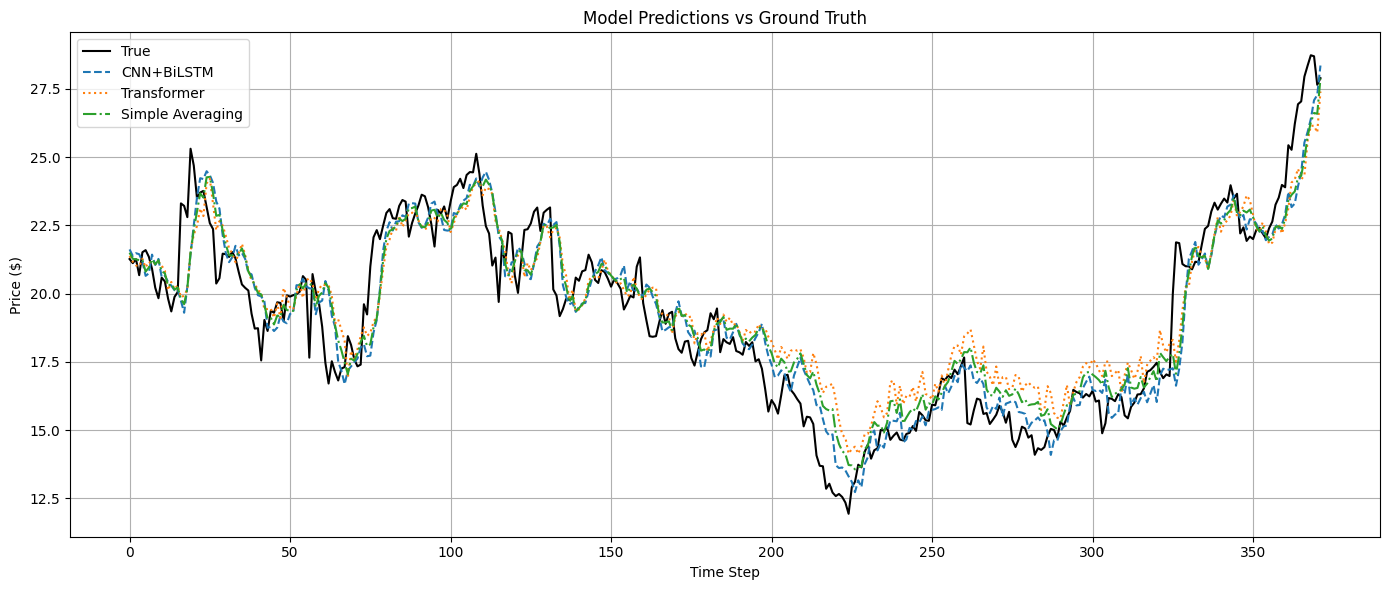

In [88]:
# ✅ Evaluate all three models
evaluate_model("CNN+BiLSTM", true_test, y_pred_cnn)
evaluate_model("Transformer", true_test, y_pred_tran)
evaluate_model("Simple Averaging", true_test, y_pred_avg)

plt.figure(figsize=(14, 6))
plt.plot(true_test, label="True", color='black')
plt.plot(y_pred_cnn, label="CNN+BiLSTM", linestyle="--")
plt.plot(y_pred_tran, label="Transformer", linestyle=":")
plt.plot(y_pred_avg, label="Simple Averaging", linestyle="-.")

plt.title("Model Predictions vs Ground Truth")
plt.xlabel("Time Step")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### MLP Stack Ensemble 

In [89]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.neural_network import MLPRegressor

param_dist = {
    'hidden_layer_sizes': [(32,), (64,), (128,), (64, 32), (128, 64), (128, 64, 32)],
    'activation': ['relu', 'tanh'],
    'alpha': uniform(0.00005, 0.003),  # broader float range
    'learning_rate_init': uniform(0.001, 0.05),
    'solver': ['adam'],
    'max_iter': randint(800, 1500)
}

search = RandomizedSearchCV(
    MLPRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=60,          # number of random combinations
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)
search.fit(X_meta_train, y_meta_train)
print("🔍 Best MLP params:", search.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END activation=relu, alpha=0.0013874982585607733, hidden_layer_sizes=(128,), learning_rate_init=0.02396244459829336, max_iter=1172, solver=adam; total time=   0.0s
[CV] END activation=relu, alpha=0.002439628960580699, hidden_layer_sizes=(128,), learning_rate_init=0.039984550013638466, max_iter=820, solver=adam; total time=   0.0s
[CV] END activation=relu, alpha=0.002439628960580699, hidden_layer_sizes=(128,), learning_rate_init=0.039984550013638466, max_iter=820, solver=adam; total time=   0.0s
[CV] END activation=relu, alpha=0.002439628960580699, hidden_layer_sizes=(128,), learning_rate_init=0.039984550013638466, max_iter=820, solver=adam; total time=   0.0s
[CV] END activation=tanh, alpha=0.00047860045376582237, hidden_layer_sizes=(128,), learning_rate_init=0.0020292247147901225, max_iter=1143, solver=adam; total time=   0.0s
[CV] END activation=relu, alpha=0.0013874982585607733, hidden_layer_sizes=(128,), learning_ra

In [90]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint
import numpy as np

# === 1. (Optional but recommended) Standardize meta features ===
scaler_meta = StandardScaler()
X_meta_train_scaled = scaler_meta.fit_transform(X_meta_train)
X_meta_test_scaled = scaler_meta.transform(X_meta_test)

# === 2. Define parameter search space (narrowed around best region) ===
param_dist = {
    'hidden_layer_sizes': [(32,), (64,), (128,), (64, 32), (128, 64)],
    'activation': ['relu', 'tanh'],
    'alpha': uniform(0.0001, 0.0006),               # Regularization ~ [0.0003, 0.0006]
    'learning_rate_init': uniform(0.005, 0.04),       # Learning rate ~ [0.02, 0.04]
    'max_iter': randint(1000, 1300),
    'solver': ['adam']
}

# === 3. Setup randomized search ===
search = RandomizedSearchCV(
    estimator=MLPRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# === 4. Run search ===
search.fit(X_meta_train_scaled, y_meta_train)
print("🔍 Best MLP params:", search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END activation=relu, alpha=0.0005779257921161397, hidden_layer_sizes=(128,), learning_rate_init=0.03618764001091077, max_iter=1020, solver=adam; total time=   0.0s
[CV] END activation=relu, alpha=0.0005779257921161397, hidden_layer_sizes=(128,), learning_rate_init=0.03618764001091077, max_iter=1020, solver=adam; total time=   0.0s
[CV] END activation=relu, alpha=0.0005779257921161397, hidden_layer_sizes=(128,), learning_rate_init=0.03618764001091077, max_iter=1020, solver=adam; total time=   0.0s
[CV] END activation=relu, alpha=0.0005779257921161397, hidden_layer_sizes=(128,), learning_rate_init=0.03618764001091077, max_iter=1020, solver=adam; total time=   0.0s
[CV] END activation=relu, alpha=0.00036749965171215465, hidden_layer_sizes=(128,), learning_rate_init=0.023369955678634688, max_iter=1099, solver=adam; total time=   0.0s
[CV] END activation=relu, alpha=0.0005779257921161397, hidden_layer_sizes=(128,), learning

In [91]:
from sklearn.neural_network import MLPRegressor

meta_model = MLPRegressor(
    hidden_layer_sizes=(512,128),
    activation='tanh',
    alpha=0.0004, # 0.0004
    learning_rate_init=0.03, # 0.04
    max_iter=1200,
    solver='adam',
    # early_stopping=True,
    # n_iter_no_change=400,
    # validation_fraction=0.2,
    random_state=42
)

meta_model.fit(X_meta_train, y_meta_train)


MLPRegressor(activation='tanh', alpha=0.0004, hidden_layer_sizes=(512, 128),
             learning_rate_init=0.03, max_iter=1200, random_state=42)

In [92]:
# Retrain base models on full training set
cnn_full = cnn_biLSTM((trainX_wo_tweet.shape[1], trainX_wo_tweet.shape[2]), 1)
cnn_full.compile(optimizer=Adam(0.001), loss=Huber(0.1), metrics=['mae'])

transformer_full = build_transformer_model((trainX_wo_tweet.shape[1], trainX_wo_tweet.shape[2]))
transformer_full.compile(optimizer=Adam(0.001), loss=Huber(0.05), metrics=['mae'])

cnn_full.fit(trainX_wo_tweet, trainY_wo_tweet, epochs=50, batch_size=64,
             validation_split=0.1, verbose=0, callbacks=[early_stop_cnn, reduce_lr_cnn])

transformer_full.fit(trainX_wo_tweet, trainY_wo_tweet, epochs=50, batch_size=64,
                     validation_split=0.1, verbose=0, callbacks=[early_stop_tran, reduce_lr_tran])

# Predict on test
testY_pred_cnn = cnn_full.predict(testX_wo_tweet).reshape(-1, 1)
testY_pred_tran = transformer_full.predict(testX_wo_tweet).reshape(-1, 1)

X_meta_test = np.hstack([testY_pred_cnn, testY_pred_tran])
y_meta_test = testY_wo_tweet.reshape(-1)

# Final ensemble prediction
y_pred_ensemble = meta_model.predict(X_meta_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [93]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred_ensemble = scaler_target.inverse_transform(y_pred_ensemble.reshape(-1, 1)).flatten()
y_meta_test     = scaler_target.inverse_transform(y_meta_test.reshape(-1, 1)).flatten()

rmse = np.sqrt(mean_squared_error(y_meta_test, y_pred_ensemble))
mae = mean_absolute_error(y_meta_test, y_pred_ensemble)
r2 = r2_score(y_meta_test, y_pred_ensemble)

print(f"📉 RMSE: {rmse:.4f}")
print(f"📉 MAE: {mae:.4f}")
print(f"📈 R² Score: {r2:.4f}")

📉 RMSE: 1.4604
📉 MAE: 1.1673
📈 R² Score: 0.8181


In [94]:
# Retrain full CNN model
cnn_final = cnn_biLSTM((trainX_wo_tweet.shape[1], trainX_wo_tweet.shape[2]), 1)
cnn_final.compile(optimizer=Adam(0.001), loss=Huber(0.1), metrics=['mae'])
cnn_final.fit(trainX_wo_tweet, trainY_wo_tweet, epochs=50, batch_size=64,
              validation_split=0.1, verbose=0,
              callbacks=[early_stop_cnn, reduce_lr_cnn])

# Retrain full Transformer model
transformer_final = build_transformer_model((trainX_wo_tweet.shape[1], trainX_wo_tweet.shape[2]))
transformer_final.compile(optimizer=Adam(0.001), loss=Huber(0.05), metrics=['mae'])
transformer_final.fit(trainX_wo_tweet, trainY_wo_tweet, epochs=50, batch_size=64,
                      validation_split=0.1, verbose=0,
                      callbacks=[early_stop_tran, reduce_lr_tran])

In [95]:
# Predict from base models
pred_cnn = cnn_final.predict(testX_wo_tweet).reshape(-1, 1)
pred_tran = transformer_final.predict(testX_wo_tweet).reshape(-1, 1)

# Inverse transform all predictions and ground truth
pred_cnn = scaler_target.inverse_transform(pred_cnn).flatten()
pred_tran = scaler_target.inverse_transform(pred_tran).flatten()
true_test = scaler_target.inverse_transform(testY_wo_tweet.reshape(-1, 1)).flatten()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
📊 CNN+BiLSTM
   RMSE: 1.2649
   MAE : 0.9473
   R²  : 0.8635

📊 Transformer
   RMSE: 1.9425
   MAE : 1.6738
   R²  : 0.6781

📊 Stacked MLP Ensemble
   RMSE: 1.4907
   MAE : 1.2119
   R²  : 0.8104



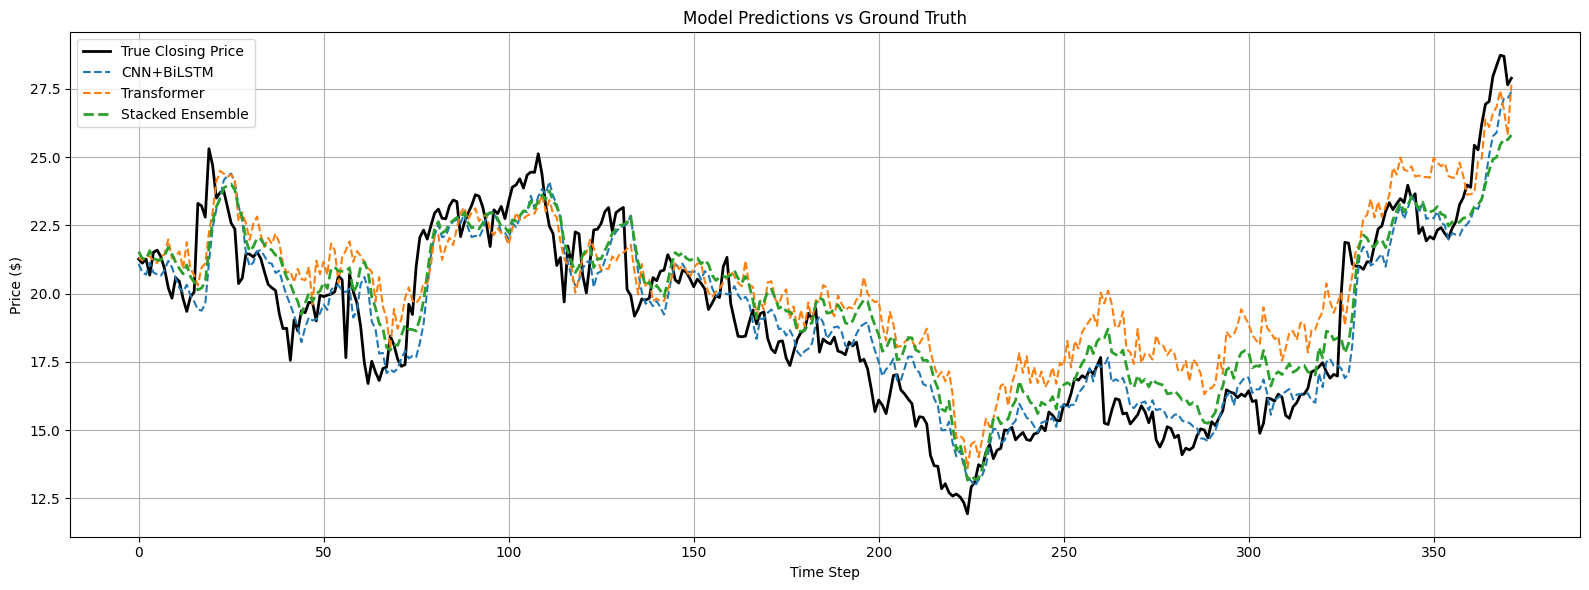

In [96]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"📊 {name}")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   MAE : {mae:.4f}")
    print(f"   R²  : {r2:.4f}\n")
    return y_pred.flatten()  # return prediction for plotting

def compare_all_models(meta_model, cnn_model, transformer_model,
                       testX_wo_tweet, testY_wo_tweet, scaler_target):
    # === Predict from base models ===
    raw_pred_cnn = cnn_model.predict(testX_wo_tweet).reshape(-1, 1)
    raw_pred_tran = transformer_model.predict(testX_wo_tweet).reshape(-1, 1)

    # === Build meta input ===
    X_meta_test = np.hstack([raw_pred_cnn, raw_pred_tran])
    raw_pred_meta = meta_model.predict(X_meta_test).reshape(-1, 1)

    # === Inverse transform all ===
    pred_cnn = scaler_target.inverse_transform(raw_pred_cnn).flatten()
    pred_tran = scaler_target.inverse_transform(raw_pred_tran).flatten()
    pred_meta = scaler_target.inverse_transform(raw_pred_meta).flatten()
    y_true = scaler_target.inverse_transform(testY_wo_tweet.reshape(-1, 1)).flatten()

    # === Evaluate ===
    y1 = evaluate_model("CNN+BiLSTM", y_true, pred_cnn)
    y2 = evaluate_model("Transformer", y_true, pred_tran)
    y3 = evaluate_model("Stacked MLP Ensemble", y_true, pred_meta)

    # === Plot all together ===
    plt.figure(figsize=(16, 6))
    plt.plot(y_true, label="True Closing Price", color="black", linewidth=2)
    plt.plot(y1, label="CNN+BiLSTM", linestyle='--')
    plt.plot(y2, label="Transformer", linestyle='--')
    plt.plot(y3, label="Stacked Ensemble", linestyle='--', linewidth=2)
    plt.title("Model Predictions vs Ground Truth")
    plt.xlabel("Time Step")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Call it ===
compare_all_models(
    meta_model=meta_model,
    cnn_model=cnn_final,
    transformer_model=transformer_final,
    testX_wo_tweet=testX_wo_tweet,
    testY_wo_tweet=testY_wo_tweet,
    scaler_target=scaler_target
)
